# ***Problem Statement*** 
## **Predicting the energy output of wind turbine based on weather condition**

Develop a time series model to Predict the power output of wind farm based on the weather condition in the site (1Hr prediction to 72Hrs. prediction) Build an application to recommend the Power Grid to suggest the best time to utilize the energy from wind farm

# **Importing Libraries and Loading Data**

In [31]:
from google.colab import drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
import math
 
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error

from fbprophet import Prophet
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import VAR

In [33]:
data=pd.read_csv('/content/drive/My Drive/Datasets /Wind Turbine Dataset.csv')
df = data.rename(columns={"LV ActivePower (kW)":"Active Power", "Wind Speed (m/s)":"Wind Speed", "Theoretical_Power_Curve (KWh)":"Theoritical Power", "Wind Direction (°)":"Direction"})
df

,Date/Time,Active Power,Wind Speed,Theoritical Power,Direction
0,01 01 2018 00:00,380.047791,5.311336,416.328908,259.994904
1,01 01 2018 00:10,453.769196,5.672167,519.917511,268.641113
2,01 01 2018 00:20,306.376587,5.216037,390.900016,272.564789
3,01 01 2018 00:30,419.645905,5.659674,516.127569,271.258087
4,01 01 2018 00:40,380.650696,5.577941,491.702972,265.674286
...,...,...,...,...,...
50525,31 12 2018 23:10,2963.980957,11.404030,3397.190793,80.502724
50526,31 12 2018 23:20,1684.353027,7.332648,1173.055771,84.062599
50527,31 12 2018 23:30,2201.106934,8.435358,1788.284755,84.742500
50528,31 12 2018 23:40,2515.694092,9.421366,2418.382503,84.297913


# **Data Pre-Processing and Plotting**

In [34]:
df['Loss']= df['Theoritical Power']-df['Active Power']
df['Loss Percent']= (df['Loss']/df['Theoritical Power']) * 100
df['Date/Time'] = pd.to_datetime(df['Date/Time'],format='%d %m %Y %H:%M')
df['Date'] = df['Date/Time'].dt.date
df['Time'] = df['Date/Time'].dt.time

df['Sin Component'] = df['Wind Speed']*np.sin(math.pi*df['Direction']/180)
df['Cos Component'] = df['Wind Speed']*np.cos(math.pi*df['Direction']/180)
df

,Date/Time,Active Power,Wind Speed,Theoritical Power,Direction,Loss,Loss Percent,Date,Time,Sin Component,Cos Component
0,2018-01-01 00:00:00,380.047791,5.311336,416.328908,259.994904,36.281117,8.714532,2018-01-01,00:00:00,-5.230563,-0.922769
1,2018-01-01 00:10:00,453.769196,5.672167,519.917511,268.641113,66.148316,12.722848,2018-01-01,00:10:00,-5.670572,-0.134514
2,2018-01-01 00:20:00,306.376587,5.216037,390.900016,272.564789,84.523429,21.622774,2018-01-01,00:20:00,-5.210812,0.233413
3,2018-01-01 00:30:00,419.645905,5.659674,516.127569,271.258087,96.481664,18.693375,2018-01-01,00:30:00,-5.658310,0.124264
4,2018-01-01 00:40:00,380.650696,5.577941,491.702972,265.674286,111.052276,22.585236,2018-01-01,00:40:00,-5.562052,-0.420723
...,...,...,...,...,...,...,...,...,...,...,...
50525,2018-12-31 23:10:00,2963.980957,11.404030,3397.190793,80.502724,433.209835,12.752002,2018-12-31,23:10:00,11.247720,1.881673
50526,2018-12-31 23:20:00,1684.353027,7.332648,1173.055771,84.062599,-511.297256,-43.586782,2018-12-31,23:20:00,7.293312,0.758502
50527,2018-12-31 23:30:00,2201.106934,8.435358,1788.284755,84.742500,-412.822178,-23.084812,2018-12-31,23:30:00,8.399870,0.772948
50528,2018-12-31 23:40:00,2515.694092,9.421366,2418.382503,84.297913,-97.311588,-4.023829,2018-12-31,23:40:00,9.374748,0.936069


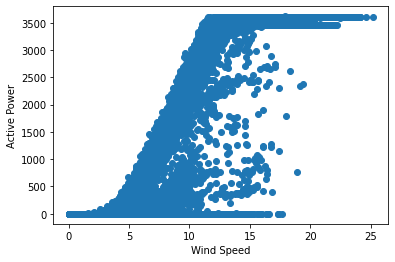

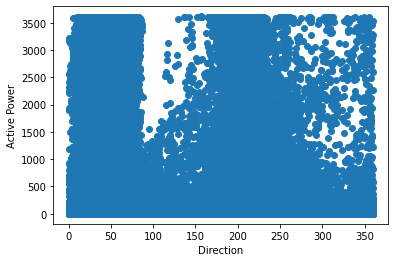

In [0]:
plt.scatter(df['Wind Speed'],df['Active Power'])
plt.xlabel('Wind Speed')
plt.ylabel('Active Power')
plt.show()

plt.scatter(df['Direction'],df['Active Power'])
plt.xlabel('Direction')
plt.ylabel('Active Power')
plt.show()

With the help of wind direction graph one can roughly conclude that the orientation of wind turbines is between 0-90 degrees and 180-270 degrees

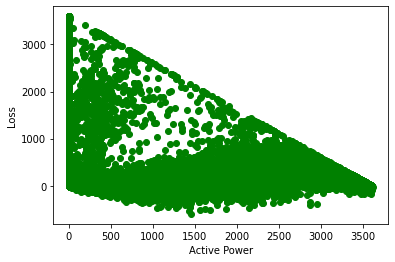

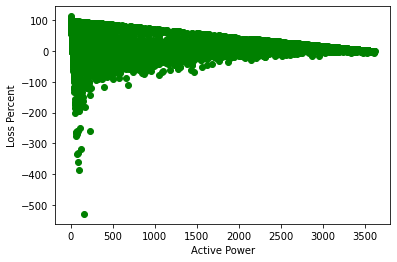

In [0]:
plt.scatter(df['Active Power'],df['Loss'],color='green')
plt.xlabel('Active Power')
plt.ylabel('Loss')
plt.show()

plt.scatter(df['Active Power'],df['Loss Percent'],color='green')
plt.xlabel('Active Power')
plt.ylabel('Loss Percent')
plt.show()

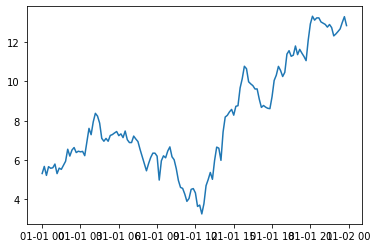

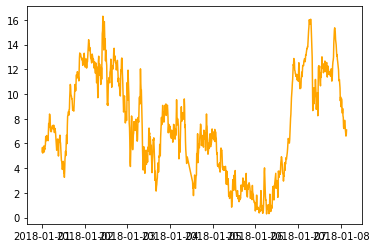

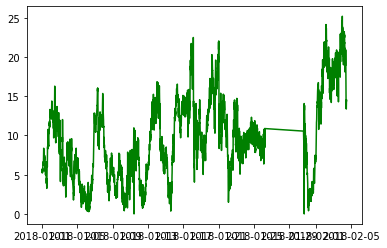

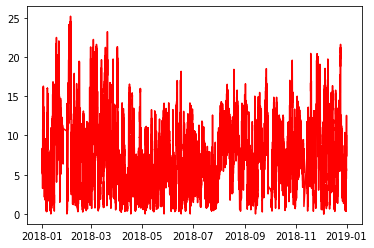

In [0]:
plt.plot(df['Date/Time'][:144],df['Wind Speed'][:144])
plt.show()
plt.plot(df['Date/Time'][:1008],df['Wind Speed'][:1008],color='orange')
plt.show()
plt.plot(df['Date/Time'][:4320],df['Wind Speed'][:4320],color='green')
plt.show()
plt.plot(df['Date/Time'],df['Wind Speed'],color='red')
plt.show()

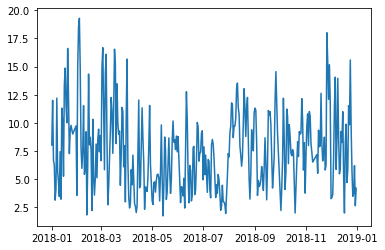

In [0]:
# plotting data for average wind speed and direction throughout the day
plot_data = df.groupby('Date')['Wind Speed'].mean()
plt.plot(plot_data.index,plot_data)
plt.show()

# **Predicting Power using Wind Speed and Direction (by MLP)**


In [0]:
X_train = df[['Wind Speed','Direction']][1000:]
Y_train = df['Active Power'][1000:]

mlp = MLPRegressor(hidden_layer_sizes=(8,8,8), activation='relu', solver='adam', max_iter=5000)
mlp.fit(X_train,Y_train)

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(8, 8, 8), learning_rate='constant',
             learning_rate_init=0.001, max_fun=15000, max_iter=5000,
             momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
             power_t=0.5, random_state=None, shuffle=True, solver='adam',
             tol=0.0001, validation_fraction=0.1, verbose=False,
             warm_start=False)

In [0]:
x_test = [[5.3,259.99]]          # for the given values, Theoritical power = 416 and Active Power = 380 
print(mlp.predict(x_test))

[169.84804168]


In [0]:
X_test = df[['Wind Speed','Direction']][:1000]
Y_test = df['Active Power'][:1000]

Y_predict = mlp.predict(X_test)

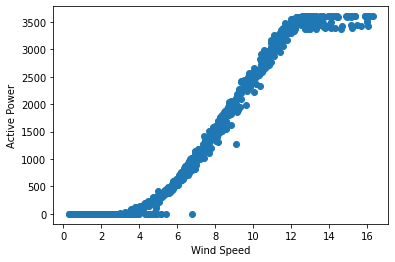

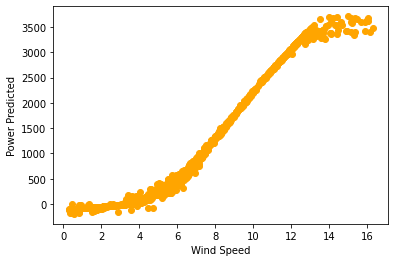

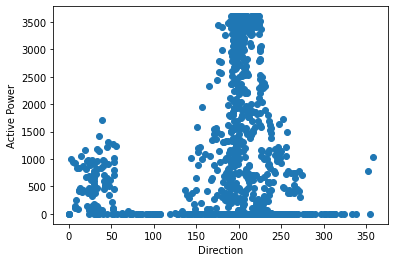

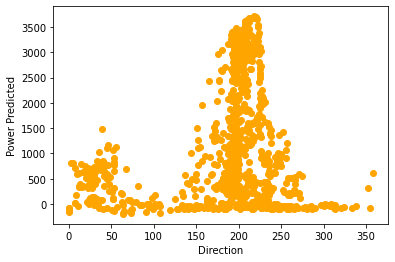

48374.391686992276

In [0]:
plt.scatter(df['Wind Speed'][:1000],df['Active Power'][:1000])
plt.xlabel('Wind Speed')  
plt.ylabel('Active Power') 
plt.show()

plt.scatter(df['Wind Speed'][:1000],Y_predict[:1000],color='orange')
plt.xlabel('Wind Speed') 
plt.ylabel('Power Predicted') 
plt.show()

plt.scatter(df['Direction'][:1000],df['Active Power'][:1000])
plt.xlabel('Direction')  
plt.ylabel('Active Power') 
plt.show()

plt.scatter(df['Direction'][:1000],Y_predict[:1000],color='orange')
plt.xlabel('Direction') 
plt.ylabel('Power Predicted') 
plt.show()

mean_squared_error(Y_test, Y_predict)

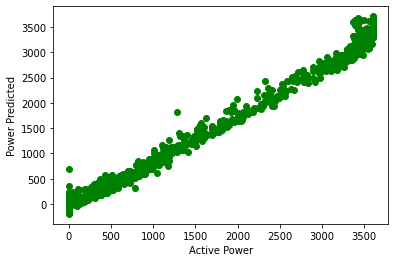

In [0]:
plt.scatter(df['Active Power'][:1000],Y_predict[:1000],color='green')
plt.xlabel('Active Power') 
plt.ylabel('Power Predicted') 
plt.show()

# **Predicting Power Using Sin and Cos Component (by MLP)**

In [0]:
X_train = df[['Sin Component','Cos Component']][1000:]
Y_train = df['Active Power'][1000:]

mlp = MLPRegressor(hidden_layer_sizes=(8,8,8), activation='relu', solver='adam', max_iter=500)
mlp.fit(X_train,Y_train)

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(8, 8, 8), learning_rate='constant',
             learning_rate_init=0.001, max_fun=15000, max_iter=500,
             momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
             power_t=0.5, random_state=None, shuffle=True, solver='adam',
             tol=0.0001, validation_fraction=0.1, verbose=False,
             warm_start=False)

In [0]:
X_test = df[['Sin Component','Cos Component']][:1000]
Y_test = df['Active Power'][:1000]

Y_predict = mlp.predict(X_test)

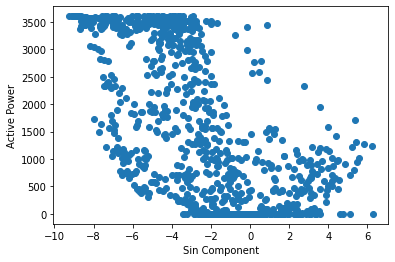

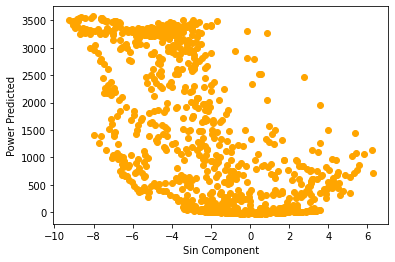

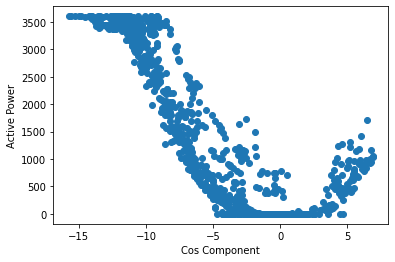

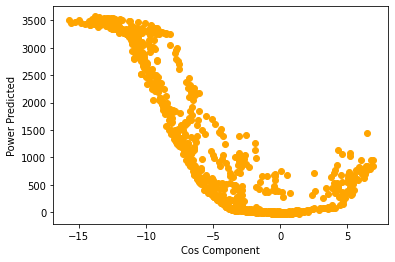

24624.707880652866

In [0]:
plt.scatter(df['Sin Component'][:1000],df['Active Power'][:1000])
plt.xlabel('Sin Component')  
plt.ylabel('Active Power') 
plt.show()

plt.scatter(df['Sin Component'][:1000],Y_predict[:1000],color='orange')
plt.xlabel('Sin Component') 
plt.ylabel('Power Predicted') 
plt.show()

plt.scatter(df['Cos Component'][:1000],df['Active Power'][:1000])
plt.xlabel('Cos Component')  
plt.ylabel('Active Power') 
plt.show()

plt.scatter(df['Cos Component'][:1000],Y_predict[:1000],color='orange')
plt.xlabel('Cos Component') 
plt.ylabel('Power Predicted') 
plt.show()

mean_squared_error(Y_test, Y_predict)

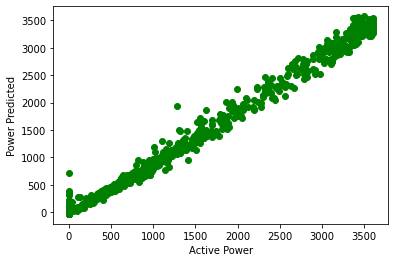

In [0]:
plt.scatter(df['Active Power'][:1000],Y_predict[:1000],color='green')
plt.xlabel('Active Power') 
plt.ylabel('Power Predicted') 
plt.show()

# **Time Series using Prophet for Wind Speed and Direction**

## Wind Speed

In [0]:
m = {'ds':df['Date/Time'][:40000],'y':df['Wind Speed'][:40000]}
data_prophet = pd.DataFrame(m)

model = Prophet(changepoint_prior_scale=0.01)
model.fit(data_prophet)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [0]:
future = model.make_future_dataframe(periods=10530, freq='10min')

forecast=model.predict(future)
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
50525,2018-12-28 02:10:00,7.430154,1.277985,13.725121,3.980545,11.176238,0.048891,0.048891,0.048891,0.416538,0.416538,0.416538,-0.367647,-0.367647,-0.367647,0.0,0.0,0.0,7.479044
50526,2018-12-28 02:20:00,7.430108,0.860762,13.918101,3.979995,11.176785,0.060560,0.060560,0.060560,0.430316,0.430316,0.430316,-0.369757,-0.369757,-0.369757,0.0,0.0,0.0,7.490668
50527,2018-12-28 02:30:00,7.430062,0.911891,13.438102,3.979445,11.177332,0.070773,0.070773,0.070773,0.442580,0.442580,0.442580,-0.371807,-0.371807,-0.371807,0.0,0.0,0.0,7.500836
50528,2018-12-28 02:40:00,7.430016,1.889631,13.690670,3.978895,11.177878,0.078970,0.078970,0.078970,0.452766,0.452766,0.452766,-0.373796,-0.373796,-0.373796,0.0,0.0,0.0,7.508987
50529,2018-12-28 02:50:00,7.429971,1.278501,13.275657,3.978345,11.178425,0.084609,0.084609,0.084609,0.460332,0.460332,0.460332,-0.375723,-0.375723,-0.375723,0.0,0.0,0.0,7.514579


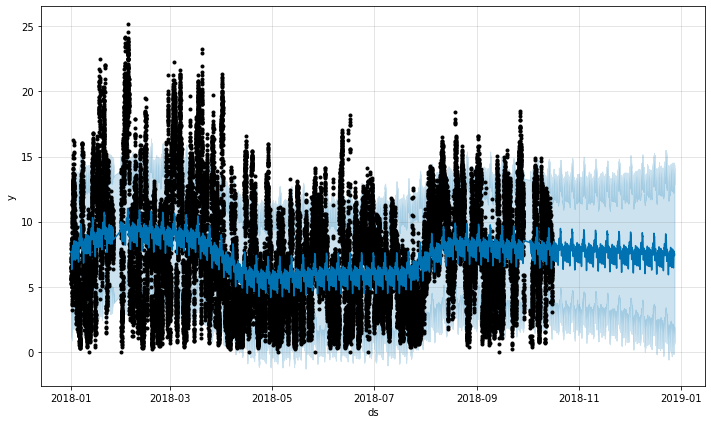

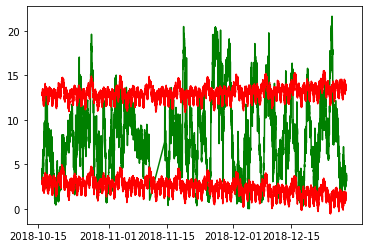

In [0]:
fig1=model.plot(forecast)
plt.show()

plt.plot(df['Date/Time'][40000:50000],df['Wind Speed'][40000:50000],color='green')
plt.plot(forecast['ds'][40000:],forecast['yhat_upper'][40000:],color='red')
plt.plot(forecast['ds'][40000:],forecast['yhat_lower'][40000:],color='red')
plt.show()

## Wind Direction 

In [0]:
m = {'ds':df['Date/Time'][:40000],'y':df['Direction'][:40000],'add1':df['Wind Speed'][:40000]}
data_prophet = pd.DataFrame(m)

model = Prophet(changepoint_prior_scale=0.01)
model.add_regressor('add1')
model.fit(data_prophet)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [0]:
future = model.make_future_dataframe(periods=10530, freq='10min')
future['add1']= df['Wind Speed']

forecast=model.predict(future)
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,add1,add1_lower,add1_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,extra_regressors_additive,extra_regressors_additive_lower,extra_regressors_additive_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
50525,2018-12-28 02:10:00,50.443271,-57.625976,163.828230,30.347326,71.766356,-13.100246,-13.100246,-13.100246,5.252932,5.252932,5.252932,10.179053,10.179053,10.179053,-13.100246,-13.100246,-13.100246,8.174125,8.174125,8.174125,0.0,0.0,0.0,55.696203
50526,2018-12-28 02:20:00,50.441213,-46.298714,181.832720,30.340857,71.767909,0.320798,0.320798,0.320798,18.517893,18.517893,18.517893,10.040110,10.040110,10.040110,0.320798,0.320798,0.320798,8.156985,8.156985,8.156985,0.0,0.0,0.0,68.959107
50527,2018-12-28 02:30:00,50.439156,-51.958714,172.583069,30.334387,71.769462,-3.314214,-3.314214,-3.314214,14.710769,14.710769,14.710769,9.886236,9.886236,9.886236,-3.314214,-3.314214,-3.314214,8.138746,8.138746,8.138746,0.0,0.0,0.0,65.149924
50528,2018-12-28 02:40:00,50.437098,-51.549951,179.213338,30.327918,71.771015,-6.564523,-6.564523,-6.564523,11.273231,11.273231,11.273231,9.718349,9.718349,9.718349,-6.564523,-6.564523,-6.564523,8.119406,8.119406,8.119406,0.0,0.0,0.0,61.710329
50529,2018-12-28 02:50:00,50.435040,-63.754507,167.832286,30.321449,71.772569,-8.403822,-8.403822,-8.403822,9.232456,9.232456,9.232456,9.537320,9.537320,9.537320,-8.403822,-8.403822,-8.403822,8.098959,8.098959,8.098959,0.0,0.0,0.0,59.667496


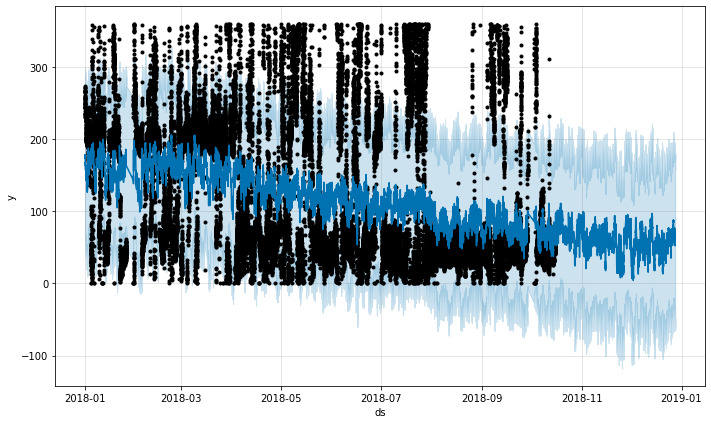

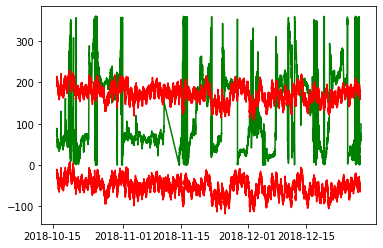

In [0]:
fig1=model.plot(forecast)
plt.show()

plt.plot(df['Date/Time'][40000:50000],df['Direction'][40000:50000],color='green')
plt.plot(forecast['ds'][40000:],forecast['yhat_upper'][40000:],color='red')
plt.plot(forecast['ds'][40000:],forecast['yhat_lower'][40000:],color='red')
plt.show()

# **Time Series Using Prophet for Sin and Cos Component**

## Sin Component 

In [91]:
m = {'ds':df['Date/Time'][:40000],'y':df['Sin Component'][:40000]}
data_prophet = pd.DataFrame(m)

model = Prophet(changepoint_prior_scale=0.01,weekly_seasonality=True,yearly_seasonality=True)
model.fit(data_prophet)

In [92]:
future = model.make_future_dataframe(periods=432, freq='10min')

forecast=model.predict(future)
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
40427,2018-10-18 23:10:00,5.808745,-3.714882,7.218945,5.808745,5.808746,-4.246932,-4.246932,-4.246932,0.071071,0.071071,0.071071,-0.593130,-0.593130,-0.593130,-3.724873,-3.724873,-3.724873,0.0,0.0,0.0,1.561813
40428,2018-10-18 23:20:00,5.808941,-3.884035,6.813269,5.808941,5.808942,-4.252357,-4.252357,-4.252357,0.070793,0.070793,0.070793,-0.591949,-0.591949,-0.591949,-3.731201,-3.731201,-3.731201,0.0,0.0,0.0,1.556584
40429,2018-10-18 23:30:00,5.809137,-3.857836,6.997445,5.809137,5.809138,-4.256400,-4.256400,-4.256400,0.071784,0.071784,0.071784,-0.590650,-0.590650,-0.590650,-3.737534,-3.737534,-3.737534,0.0,0.0,0.0,1.552737
40430,2018-10-18 23:40:00,5.809333,-3.779392,6.925172,5.809333,5.809334,-4.259326,-4.259326,-4.259326,0.073777,0.073777,0.073777,-0.589231,-0.589231,-0.589231,-3.743872,-3.743872,-3.743872,0.0,0.0,0.0,1.550007
40431,2018-10-18 23:50:00,5.809529,-3.698599,6.504901,5.809529,5.809530,-4.261391,-4.261391,-4.261391,0.076516,0.076516,0.076516,-0.587694,-0.587694,-0.587694,-3.750213,-3.750213,-3.750213,0.0,0.0,0.0,1.548138


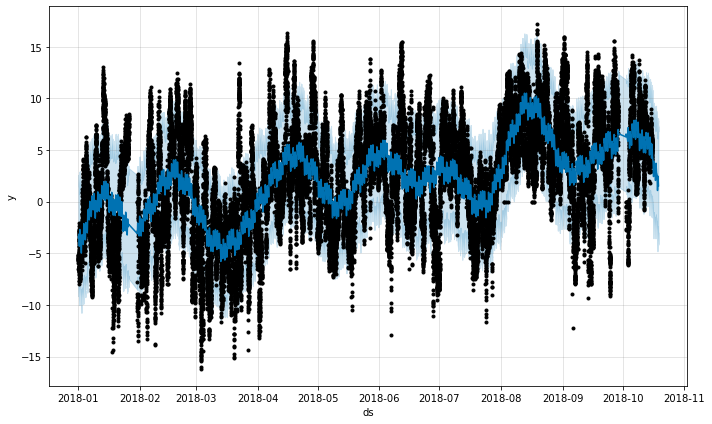

In [93]:
fig1=model.plot(forecast)
plt.show()

# plt.plot(df['Date/Time'][40000:50000],df['Sin Component'][40000:50000],color='green')
# plt.plot(forecast['ds'][40000:],forecast['yhat'][40000:],color='blue')
# plt.plot(forecast['ds'][40000:],forecast['yhat_upper'][40000:],color='red')
# plt.plot(forecast['ds'][40000:],forecast['yhat_lower'][40000:],color='red')
# plt.show()

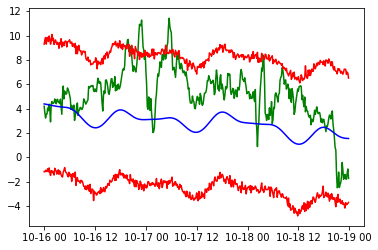

In [94]:
plt.plot(df['Date/Time'][40000:40432],df['Sin Component'][40000:40432],color='green')
plt.plot(forecast['ds'][40000:40432],forecast['yhat'][40000:40432],color='blue')
plt.plot(forecast['ds'][40000:40432],forecast['yhat_lower'][40000:40432],color='red')
plt.plot(forecast['ds'][40000:40432],forecast['yhat_upper'][40000:40432],color='red')
plt.show()

## Cos Component

In [40]:
m = {'ds':df['Date/Time'][:40000],'y':df['Cos Component'][:40000],'add1':df['Sin Component'][:40000]}
data_prophet = pd.DataFrame(m)

model = Prophet(changepoint_prior_scale=0.01)
model.add_regressor('add1')
model.fit(data_prophet)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [41]:
future = model.make_future_dataframe(periods=10530, freq='10min')
future['add1']= forecast['yhat']

forecast=model.predict(future)
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,add1,add1_lower,add1_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,extra_regressors_additive,extra_regressors_additive_lower,extra_regressors_additive_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
50525,2018-12-28 02:10:00,2.045717,-2.286771,9.017727,0.168610,4.039724,1.561618,1.561618,1.561618,1.496709,1.496709,1.496709,-0.686664,-0.686664,-0.686664,1.561618,1.561618,1.561618,0.621755,0.621755,0.621755,0.0,0.0,0.0,3.542426
50526,2018-12-28 02:20:00,2.045710,-2.311838,9.388127,0.167938,4.039939,1.565823,1.565823,1.565823,1.483879,1.483879,1.483879,-0.699561,-0.699561,-0.699561,1.565823,1.565823,1.565823,0.617617,0.617617,0.617617,0.0,0.0,0.0,3.529589
50527,2018-12-28 02:30:00,2.045703,-2.360725,9.136338,0.167266,4.040153,1.570397,1.570397,1.570397,1.470179,1.470179,1.470179,-0.713632,-0.713632,-0.713632,1.570397,1.570397,1.570397,0.613414,0.613414,0.613414,0.0,0.0,0.0,3.515881
50528,2018-12-28 02:40:00,2.045696,-2.022125,9.122223,0.166594,4.040368,1.575414,1.575414,1.575414,1.455879,1.455879,1.455879,-0.728682,-0.728682,-0.728682,1.575414,1.575414,1.575414,0.609147,0.609147,0.609147,0.0,0.0,0.0,3.501575
50529,2018-12-28 02:50:00,2.045688,-1.951501,9.321632,0.165922,4.040583,1.580937,1.580937,1.580937,1.441247,1.441247,1.441247,-0.744507,-0.744507,-0.744507,1.580937,1.580937,1.580937,0.604817,0.604817,0.604817,0.0,0.0,0.0,3.486935


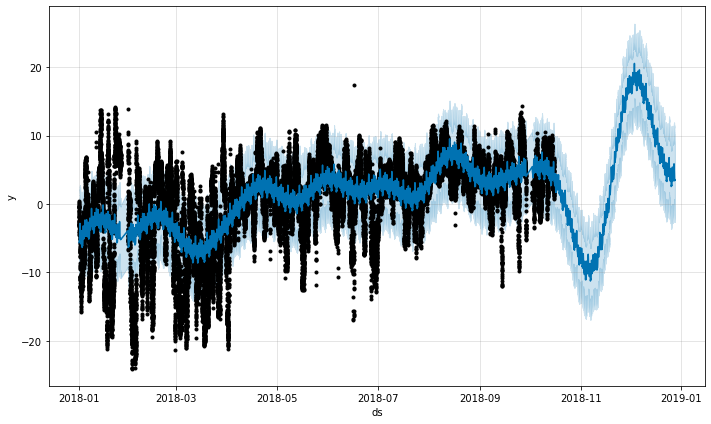

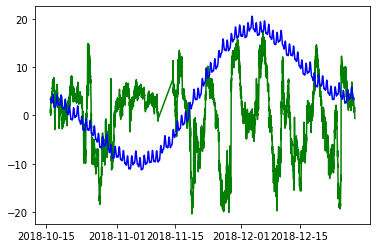

In [42]:
fig1=model.plot(forecast)
plt.show()

plt.plot(df['Date/Time'][40000:50000],df['Cos Component'][40000:50000],color='green')
plt.plot(forecast['ds'][40000:],forecast['yhat'][40000:],color='blue')
plt.show()

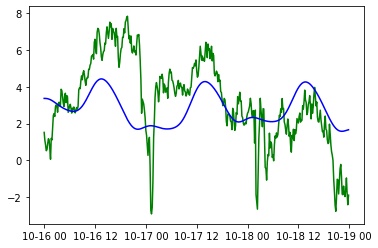

In [43]:
plt.plot(df['Date/Time'][40000:40432],df['Cos Component'][40000:40432],color='green')
plt.plot(forecast['ds'][40000:40432],forecast['yhat'][40000:40432],color='blue')
plt.show()

So for the Prophet model sort of correctly predicts the trend in the values. It is obvious that the values predicted are not accurate but it can be seen that the trend has been accurately predicted by prophet model for the sin and cos components for the next 72 hours given the time seires data for the last 365 days.

Also adding the regressor has proved very useful in the correct analysis of trend which is clearly shown in the last graph. 

## Sin on Weekly 

In [79]:
m = {'ds':df['Date/Time'][:1008],'y':df['Sin Component'][:1008]}
data_prophet = pd.DataFrame(m)

model = Prophet(changepoint_prior_scale=0.01,weekly_seasonality=True)
model.fit(data_prophet)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [80]:
future = model.make_future_dataframe(periods=432, freq='10min')

forecast=model.predict(future)
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1435,2018-01-11 02:40:00,-3.686766,-3.770326,0.854345,-3.686816,-3.686714,2.272952,2.272952,2.272952,0.556224,0.556224,0.556224,1.716728,1.716728,1.716728,0.0,0.0,0.0,-1.413814
1436,2018-01-11 02:50:00,-3.688242,-3.716008,1.031529,-3.688292,-3.688189,2.257981,2.257981,2.257981,0.517743,0.517743,0.517743,1.740238,1.740238,1.740238,0.0,0.0,0.0,-1.430260
1437,2018-01-11 03:00:00,-3.689717,-3.941946,1.067552,-3.689767,-3.689664,2.234588,2.234588,2.234588,0.470797,0.470797,0.470797,1.763791,1.763791,1.763791,0.0,0.0,0.0,-1.455129
1438,2018-01-11 03:10:00,-3.691192,-3.783720,0.828788,-3.691243,-3.691139,2.203634,2.203634,2.203634,0.416253,0.416253,0.416253,1.787381,1.787381,1.787381,0.0,0.0,0.0,-1.487558
1439,2018-01-11 03:20:00,-3.692667,-3.804721,0.781931,-3.692718,-3.692614,2.166128,2.166128,2.166128,0.355124,0.355124,0.355124,1.811005,1.811005,1.811005,0.0,0.0,0.0,-1.526539


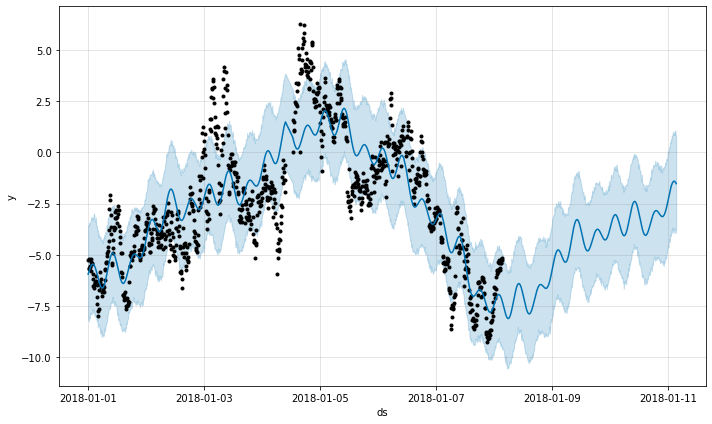

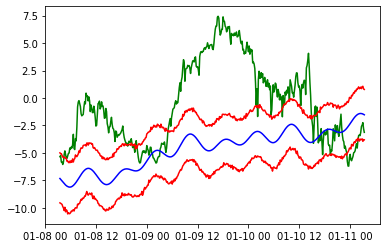

In [81]:
fig1=model.plot(forecast)
plt.show()

plt.plot(df['Date/Time'][1008:1440],df['Sin Component'][1008:1440],color='green')
plt.plot(forecast['ds'][1008:1440],forecast['yhat'][1008:1440],color='blue')
plt.plot(forecast['ds'][1008:1440],forecast['yhat_upper'][1008:1440],color='red')
plt.plot(forecast['ds'][1008:1440],forecast['yhat_lower'][1008:1440],color='red')
plt.show()

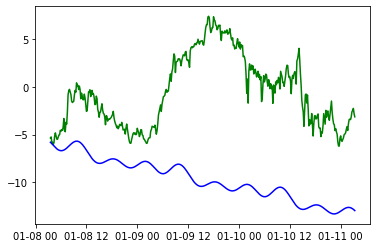

In [78]:
plt.plot(df['Date/Time'][1008:1440],df['Sin Component'][1008:1440],color='green')
plt.plot(forecast['ds'][1008:1440],forecast['yhat'][1008:1440],color='blue')
plt.show()

# **Multivariate Time Series Using VAR on Sin and Cos Components**

## Using Values of last 11 months

In [0]:
var_data = pd.DataFrame({'sc':df['Sin Component'][:40000],'cc':df['Cos Component'][:40000]})
print(var_data.dtypes)
print(var_data)

sc    float64
cc    float64
dtype: object
             sc        cc
0     -5.230563 -0.922769
1     -5.670572 -0.134514
2     -5.210812  0.233413
3     -5.658310  0.124264
4     -5.562052 -0.420723
...         ...       ...
39995  4.458130  1.345239
39996  4.135605  1.193847
39997  3.694527  1.195820
39998  3.575136  0.926870
39999  2.971723  0.728535

[40000 rows x 2 columns]


In [0]:
model = VAR(var_data)
model_fit = model.fit(2000)

In [0]:
pred = model_fit.forecast(model_fit.y, steps=10530)
print(pred)
pred.dtype

/usr/local/lib/python3.6/dist-packages/statsmodels/base/wrapper.py:35: FutureWarning:

y is a deprecated alias for endog, will be removed in version 0.11.0



[[3.20214098 0.69252785]
 [3.32648803 0.94190529]
 [3.33391797 0.69235275]
 ...
 [2.68170646 1.44344842]
 [2.68263675 1.4455912 ]
 [2.68366032 1.44758603]]


dtype('float64')

In [0]:
predicted = pd.DataFrame(pred, columns = ['Sin Value', 'Cos Value'])
predicted

,Sin Value,Cos Value
0,3.202141,0.692528
1,3.326488,0.941905
2,3.333918,0.692353
3,3.147791,0.255909
4,3.121509,0.554934
...,...,...
10525,2.679888,1.438428
10526,2.680819,1.440957
10527,2.681706,1.443448
10528,2.682637,1.445591


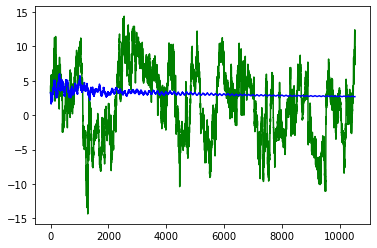

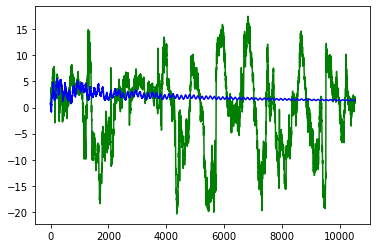

In [0]:
# plt.plot(pred)
plt.plot(df.index[:10530],df['Sin Component'][40000:],color='green')
plt.plot(predicted.index[:10530],predicted['Sin Value'][:10530],color='blue')
plt.show()
plt.plot(df.index[:10530],df['Cos Component'][40000:],color='green')
plt.plot(predicted.index[:10530],predicted['Cos Value'][:10530],color='blue')
plt.show()

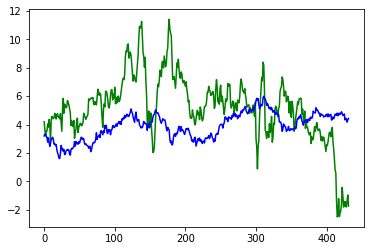

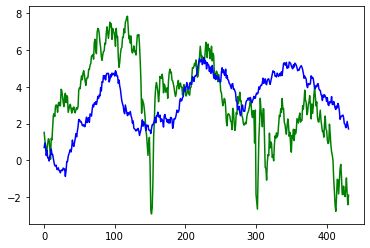

In [0]:
plt.plot(df.index[:432],df['Sin Component'][40000:40432],color='green')
plt.plot(predicted.index[:432],predicted['Sin Value'][:432],color='blue')
plt.show()

plt.plot(df.index[:432],df['Cos Component'][40000:40432],color='green')
plt.plot(predicted.index[:432],predicted['Cos Value'][:432],color='blue')
plt.show()

## Using Last 3 months values 

In [25]:
var_data = pd.DataFrame({'sc':df['Sin Component'][:12960],'cc':df['Cos Component'][:12960]})
print(var_data.dtypes)
print(var_data)

sc    float64
cc    float64
dtype: object
             sc        cc
0     -5.230563 -0.922769
1     -5.670572 -0.134514
2     -5.210812  0.233413
3     -5.658310  0.124264
4     -5.562052 -0.420723
...         ...       ...
12955  0.828262  0.181560
12956  1.190163  1.573940
12957  1.522725  0.613570
12958  1.153228  1.145543
12959  0.820088  0.753499

[12960 rows x 2 columns]


In [0]:
model = VAR(var_data)
model_fit = model.fit(2000)

In [0]:
pred = model_fit.forecast(model_fit.y, steps=432)
print(pred)
pred.dtype

In [28]:
predicted = pd.DataFrame(pred, columns = ['Sin Value', 'Cos Value'])
predicted

,Sin Value,Cos Value
0,1.344549,0.892417
1,0.189623,-0.473012
2,0.441314,-0.442588
3,0.994727,0.253491
4,0.422578,-0.103702
...,...,...
427,-5.447217,-9.967980
428,-5.744551,-10.613041
429,-5.263925,-9.434523
430,-5.236002,-10.096468


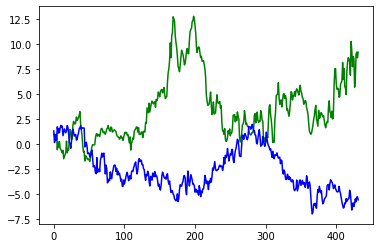

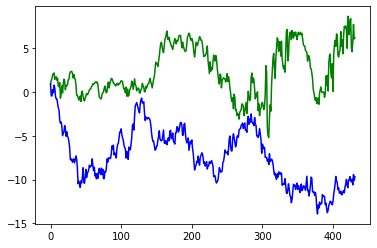

In [30]:
plt.plot(df.index[:432],df['Sin Component'][12960:13392],color='green')
plt.plot(predicted.index[:432],predicted['Sin Value'][:432],color='blue')
plt.show()

plt.plot(df.index[:432],df['Cos Component'][12960:13392],color='green')
plt.plot(predicted.index[:432],predicted['Cos Value'][:432],color='blue')
plt.show()

# **Using Prophet Time Series on Power** 


In [66]:
m = {'ds':df['Date/Time'][:432],'y':df['Active Power'][:432]}
data_prophet = pd.DataFrame(m)

model = Prophet(changepoint_prior_scale=0.01)
model.fit(data_prophet)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


In [67]:
future = model.make_future_dataframe(periods=432, freq='10min')

forecast=model.predict(future)
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
859,2018-01-06 23:10:00,365.003938,-636.329931,2212.954631,52.872686,695.335441,429.178859,429.178859,429.178859,429.178859,429.178859,429.178859,0.0,0.0,0.0,794.182797
860,2018-01-06 23:20:00,362.371056,-791.091873,2187.215063,48.894414,693.730847,371.650750,371.650750,371.650750,371.650750,371.650750,371.650750,0.0,0.0,0.0,734.021806
861,2018-01-06 23:30:00,359.738174,-757.044504,2120.539848,45.815708,692.224252,313.023906,313.023906,313.023906,313.023906,313.023906,313.023906,0.0,0.0,0.0,672.762080
862,2018-01-06 23:40:00,357.105292,-850.702978,2128.615296,42.833295,691.809321,254.070806,254.070806,254.070806,254.070806,254.070806,254.070806,0.0,0.0,0.0,611.176097
863,2018-01-06 23:50:00,354.472409,-941.416853,2018.636985,39.325928,691.287213,195.555091,195.555091,195.555091,195.555091,195.555091,195.555091,0.0,0.0,0.0,550.027501


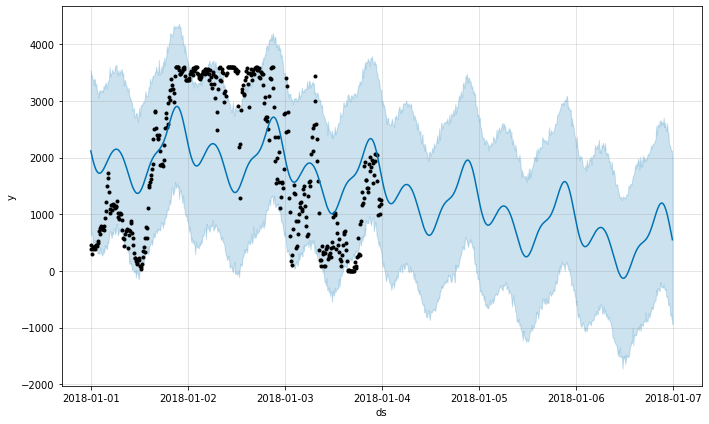

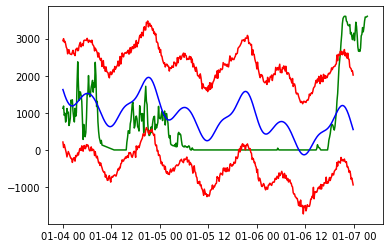

In [70]:
fig1=model.plot(forecast)
plt.show()

plt.plot(df['Date/Time'][432:864],df['Active Power'][432:864],color='green')
plt.plot(forecast['ds'][432:864],forecast['yhat'][432:864],color='blue')
plt.plot(forecast['ds'][432:864],forecast['yhat_upper'][432:864],color='red')
plt.plot(forecast['ds'][432:864],forecast['yhat_lower'][432:864],color='red')
plt.show()

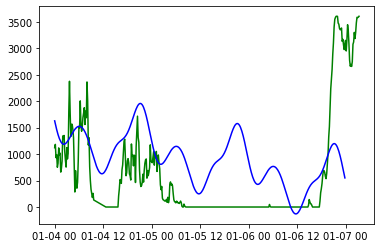

In [71]:
plt.plot(df['Date/Time'][432:864],df['Active Power'][432:864],color='green')
plt.plot(forecast['ds'][432:864],forecast['yhat'][432:864],color='blue')
plt.show()

# **Conclusion**
Thus as is seen directly from the graphs the VAR Model proves as one of the best in order to predict the tie series data. The main problem with this data is that there are a lot of fluctutions in a very short time interval and the magnitude of these fluctuations is also large. 

Besides we caanot even use moving averages as using them would destroy the characteristic of the next component due to large fluctuations. 